In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
path = 'drive/MyDrive/TIP'

import shutil
import pandas as pd
import os
# # remove folders
# shutil.rmtree(path+'/test-resized')
# shutil.rmtree(path+'/train-resized')

# # # Extract the folders train and test
# shutil.unpack_archive(path+'/train-resized.zip',path,'zip')
# shutil.unpack_archive(path+'/test-resized.zip',path,'zip')

In [2]:
import os

print(len(os.listdir(path+"/train-resized")))
print(len(os.listdir(path+"/test-resized")))

# définir les paths des dossiers et des fichier.csv
path = 'drive/MyDrive/TIP'
train_path = path +'/train-resized'
train_csv_path = path +'/train-labels.csv'
test_path = path +'/test-resized'
test_csv_path = path +'/test-name.csv'

33126
10982


In [3]:
#Imports

!pip3 install tqdm
import numpy as np
from tqdm import tqdm
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader,Dataset,random_split,WeightedRandomSampler
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd
from torchvision.io import read_image
from collections import Counter

In [4]:
#Chargement des données
#Définition des classes
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.target=torch.tensor(self.img_labels.iloc[:, 1])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+".jpg")
        image = read_image(img_path)
        #preprocess img
        image=image.float()
        image *= (1.0/image.max())
        label = self.img_labels.iloc[idx, 1]
        label=torch.tensor(float(label)) #preprocess label
        if label.item()==1. and self.transform:
            image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        return image, label

class CustomImageTestset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_name = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_name.iloc[idx,0]+".jpg")
        image = read_image(img_path)
        name=self.img_name.iloc[idx,0]
        image=image.float()
        image *= (1.0/image.max())
        if self.transform:
            image = self.transform(image)
        return image,name



In [5]:
#Variables
FT=0
augment=1
batch_size = 64
samp=1

Classe du dataset train+val : (tensor([0, 1]), tensor([32542,   584]))
-------------------------------
Classe du dataset train : {0: 29301, 1: 512}
-------------------------------
Taille image train : torch.Size([3, 224, 224]), Label : torch.Size([])
   ----------------------------


<ipython-input-6-0587b7bce8fe>:34: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  plt.imshow(sample[0].T)


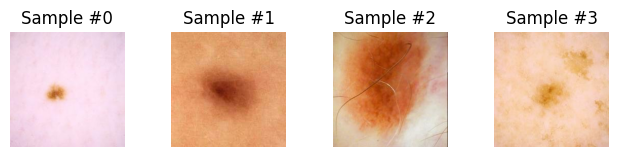

Classe du dataset de validation : {0: 3241, 1: 72}
-------------------------------
Taille image val: torch.Size([3, 224, 224]), Label : torch.Size([])
   ----------------------------


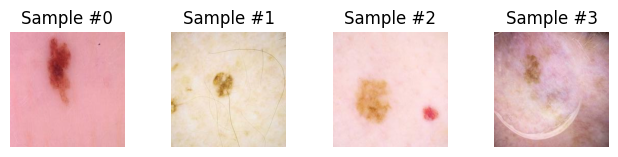

Dataset de test 
-------------------------------
Taille image test: torch.Size([3, 224, 224])
   ----------------------------


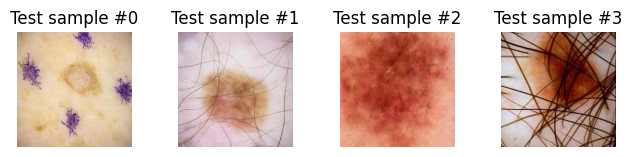

In [6]:
#Chargement des données
#Instanciation des dataloaders

# Define data augmentation transforms
data_augm = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

if augment :
    dataset=CustomImageDataset(annotations_file=train_csv_path,img_dir=train_path ,transform=data_augm)
else:
    dataset=CustomImageDataset(annotations_file=train_csv_path,img_dir=train_path )

print(f"Classe du dataset train+val : {torch.unique(dataset.target, return_counts=True)}\n-------------------------------")

#Division entre train et val
generator1 = torch.Generator().manual_seed(42)
l=len(dataset)
train_dataset,val_dataset=random_split(dataset,[round(0.9*l), round(0.1*l)], generator=generator1)

test_dataset=CustomImageTestset(annotations_file= test_csv_path,img_dir=test_path )

print(f"Classe du dataset train : {dict(Counter(train_dataset.dataset.img_labels.iloc[i,1] for i in train_dataset.indices))}\n-------------------------------")

for i, sample in enumerate(train_dataset):
    if i == 0:
        print(f"Taille image train : {sample[0].shape}, Label : {sample[1].shape}\n   ----------------------------")
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0].T)
    if i == 3:
        plt.show()
        break
print(f"Classe du dataset de validation : {dict(Counter(val_dataset.dataset.img_labels.iloc[i,1] for i in val_dataset.indices))}\n-------------------------------")
for i, sample in enumerate(val_dataset):
    if i == 0:
        print(f"Taille image val: {sample[0].shape}, Label : {sample[1].shape}\n   ----------------------------")
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0].T)
    if i == 3:
        plt.show()
        break

print(f"Dataset de test \n-------------------------------")
for i, (sample,name) in enumerate(test_dataset):
    if i == 0:
        print(f"Taille image test: {sample.shape}\n   ----------------------------")
    ay = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ay.set_title('Test sample #{}'.format(i))
    # ay.xlabel(name)
    ay.axis('off')
    plt.imshow(sample.T)
    if i == 3:
        plt.show()
        break

In [7]:
#Mise en forme des données

#distribue les classes dans chaque sample
label_train = [train_dataset.dataset.img_labels.iloc[i,1] for i in train_dataset.indices]
class_sample_count = np.array([len(np.where(label_train == t)[0]) for t in np.unique(label_train)])
weight = 1. / class_sample_count
weight[1]=0.07*weight[1]
samples_weight = np.array([weight[t] for t in label_train])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight),replacement=True)

# Create data loaders.
if samp:
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=4,sampler=sampler)
else:
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True,num_workers=4)
val_dataloader=DataLoader(val_dataset, batch_size=batch_size,shuffle=False,num_workers=4)

for X,y in train_dataloader:
    print(f"Classe du batch : {np.array([len(torch.where(y == t)[0]) for t in torch.unique(y)])}\n-------------------------------")
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Classe du batch : [59  5]
-------------------------------
Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.float32


In [8]:
# Création du modèle
import torchvision.models as models #import resnet18, ResNet18_Weights
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

# Define model
model = models.resnet50(pretrained=True)
#freeze params
if not FT:
    for name, params in model.named_parameters():
        params.requires_grad = False # Freeze parameters

# print(params)
model= model.cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model.fc = model.fc.cuda()  if device=="cuda" else net.fc
# print(model)

Using cuda device


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
#défini la fonction de perte et l'optimiseur
pos_weight=torch.tensor(class_sample_count[0]/class_sample_count[1])
loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
if FT:
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
else:
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

In [10]:
#val
def val(model,loss_fn,val_dataloader,csv_file,send,loss=None,nb="Last"):
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    total_samples_0 = 0
    total_samples_1 = 0
    correct_predictions_0 = 0
    correct_predictions_1 = 0
    num_batches = len(val_dataloader)

    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        for val_batch, (val_X, val_y) in enumerate(val_dataloader):
            val_X, val_y = val_X.to(device), val_y.to(device)
            val_pred = model(val_X)
            val_loss += loss_fn(val_pred.squeeze(), val_y).item()
            # Calculate accuracy for each class
            predicted_labels=torch.sigmoid(val_pred.T)
            correct_predictions_0 += ((val_y == 0) & (predicted_labels < 0.5)).sum().item()
            correct_predictions_1 += ((val_y == 1) & (predicted_labels >= 0.5)).sum().item()
            total_samples_0 += (val_y == 0).sum().item()
            total_samples_1 += (val_y == 1).sum().item()

        accuracy_0 = correct_predictions_0 / total_samples_0
        accuracy_1 = correct_predictions_1 / total_samples_1
        accuracy_gen= (correct_predictions_0+correct_predictions_1) / (total_samples_0+total_samples_1)
        avg_val_loss = val_loss / (val_batch + 1)
        with open(csv_file, 'a', newline='') as file:
            writer = csv.writer(file)
            if loss==None:
                writer.writerow([nb,round(accuracy_gen,3),round(accuracy_0,3),round(accuracy_1,3),round(avg_val_loss,3)]+send)
            else:
                writer.writerow([nb,round(accuracy_gen,3),round(accuracy_0,3),round(accuracy_1,3),round(avg_val_loss,3),torch.round(loss,decimals=3).item()]+send)





In [11]:
#training
epochs=15
nb_batch=len(train_dataloader)

if FT :
    if augment :
        filename='valAugmFT'+str(batch_size)+"_"+str(epochs)+"epo"+'.csv'
    else:
        filename='valFT'+str(batch_size)+"_"+str(epochs)+"epo"+'.csv'
else:
    if augment :
         filename='valAugmFE'+str(batch_size)+"_"+str(epochs)+"epo"+'.csv'
    else:
         filename='valFE'+str(batch_size)+"_"+str(epochs)+"epo"+'.csv'

with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    field = ["epoch","gen acc","acc0","acc1","val_loss","loss","acc0_train","acc1_train","accGen_train"]
    writer.writerow(field)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    size = len(train_dataset)
    model.train()
    total_samples_0 = 0
    total_samples_1 = 0
    correct_predictions_0 = 0
    correct_predictions_1 = 0
    for batch, (X, y) in tqdm(enumerate(train_dataloader), total=nb_batch):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # ---------------------------------------------------------------------------
    total_samples_0 = 0
    total_samples_1 = 0
    correct_predictions_0 = 0
    correct_predictions_1 = 0
    predicted_labels=torch.sigmoid(pred.T)
    correct_predictions_0 += ((y == 0) & (predicted_labels < 0.5)).sum().item()
    correct_predictions_1 += ((y == 1) & (predicted_labels >= 0.5)).sum().item()
    total_samples_0 += (y == 0).sum().item()
    total_samples_1 += (y == 1).sum().item()
    accuracy_0 = correct_predictions_0 / total_samples_0
    accuracy_1 = correct_predictions_1 / total_samples_1
    accuracy_gen= (correct_predictions_0+correct_predictions_1) / (total_samples_0+total_samples_1)
    #--------------------------------------------------------------------------------
    send = [accuracy_0,accuracy_1,accuracy_gen]

    val(model,loss_fn,val_dataloader,filename,send,loss=loss,nb=t)
        # if batch+1 % round((nb_batch-1)/3) == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


print(filename+" done!")


Epoch 1
-------------------------------


100%|██████████| 466/466 [02:04<00:00,  3.75it/s]


Epoch 2
-------------------------------


100%|██████████| 466/466 [01:42<00:00,  4.56it/s]


Epoch 3
-------------------------------


100%|██████████| 466/466 [01:41<00:00,  4.59it/s]


Epoch 4
-------------------------------


100%|██████████| 466/466 [01:41<00:00,  4.57it/s]


Epoch 5
-------------------------------


100%|██████████| 466/466 [01:41<00:00,  4.58it/s]


Epoch 6
-------------------------------


100%|██████████| 466/466 [01:41<00:00,  4.57it/s]


Epoch 7
-------------------------------


100%|██████████| 466/466 [01:42<00:00,  4.56it/s]


Epoch 8
-------------------------------


100%|██████████| 466/466 [01:42<00:00,  4.57it/s]


Epoch 9
-------------------------------


100%|██████████| 466/466 [01:41<00:00,  4.58it/s]


Epoch 10
-------------------------------


100%|██████████| 466/466 [01:42<00:00,  4.55it/s]


Epoch 11
-------------------------------


100%|██████████| 466/466 [01:41<00:00,  4.58it/s]


Epoch 12
-------------------------------


100%|██████████| 466/466 [01:41<00:00,  4.57it/s]


Epoch 13
-------------------------------


100%|██████████| 466/466 [01:42<00:00,  4.55it/s]


Epoch 14
-------------------------------


100%|██████████| 466/466 [01:42<00:00,  4.55it/s]


Epoch 15
-------------------------------


100%|██████████| 466/466 [01:41<00:00,  4.57it/s]


valAugmFE64_15epo.csv done!


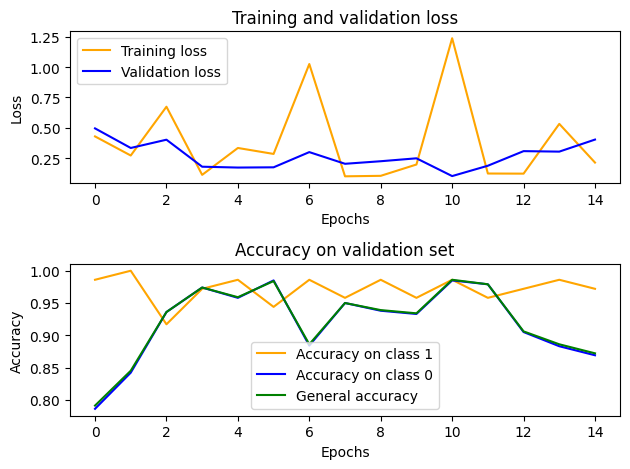

In [12]:
#Visualize data

figure, axis = plt.subplots(2, 1)
csv_file=pd.read_csv(filename)
axis[0].plot(csv_file["epoch"], csv_file["loss"], color='orange', label='Training loss')
axis[0].plot(csv_file["epoch"], csv_file["val_loss"], 'b', label='Validation loss')
axis[0].set_title('Training and validation loss')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].legend()

axis[1].plot(csv_file["epoch"], csv_file["acc1"], color='orange', label='Accuracy on class 1')
axis[1].plot(csv_file["epoch"], csv_file["acc0"], 'b', label='Accuracy on class 0')
axis[1].plot(csv_file["epoch"], csv_file["gen acc"], 'g', label='General accuracy')
axis[1].set_title('Accuracy on validation set')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')
axis[1].legend()

plt.tight_layout()
if FT :
    if augment :
        plt.savefig("Metrics_FT_augm"+str(batch_size)+"_"+str(epochs)+"epo"+".png")
    else:
        plt.savefig("Metrics_FT"+str(batch_size)+"_"+str(epochs)+"epo"+".png")
else:
    if augment :
         plt.savefig("Metrics_FE_augm"+str(batch_size)+"_"+str(epochs)+"epo"+".png")
    else:
         plt.savefig("Metrics_FE"+str(batch_size)+"_"+str(epochs)+"epo"+".png")

plt.show()

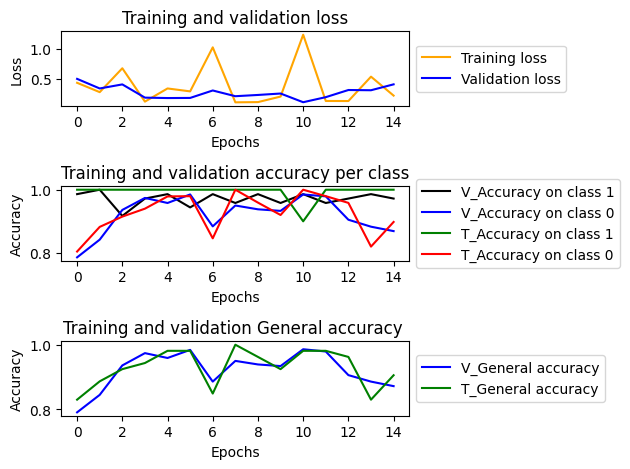

In [13]:
#Visualize data

figure, axis = plt.subplots(3, 1)
csv_file=pd.read_csv(filename)
axis[0].plot(csv_file["epoch"], csv_file["loss"], color='orange', label='Training loss')
axis[0].plot(csv_file["epoch"], csv_file["val_loss"], 'b', label='Validation loss')
axis[0].set_title('Training and validation loss')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axis[1].plot(csv_file["epoch"], csv_file["acc1"], color='black', label='V_Accuracy on class 1')
axis[1].plot(csv_file["epoch"], csv_file["acc0"], 'b', label='V_Accuracy on class 0')
axis[1].plot(csv_file["epoch"], csv_file["acc1_train"], color='green', label='T_Accuracy on class 1')
axis[1].plot(csv_file["epoch"], csv_file["acc0_train"], color='red', label='T_Accuracy on class 0')
axis[1].set_title('Training and validation accuracy per class')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')

axis[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


axis[2].plot(csv_file["epoch"], csv_file["gen acc"], 'b', label='V_General accuracy')
axis[2].plot(csv_file["epoch"], csv_file["accGen_train"], 'g', label='T_General accuracy')
axis[2].set_title('Training and validation General accuracy ')
axis[2].set_xlabel('Epochs')
axis[2].set_ylabel('Accuracy')
axis[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig("Metrics"+str(batch_size)+".png")
plt.show()

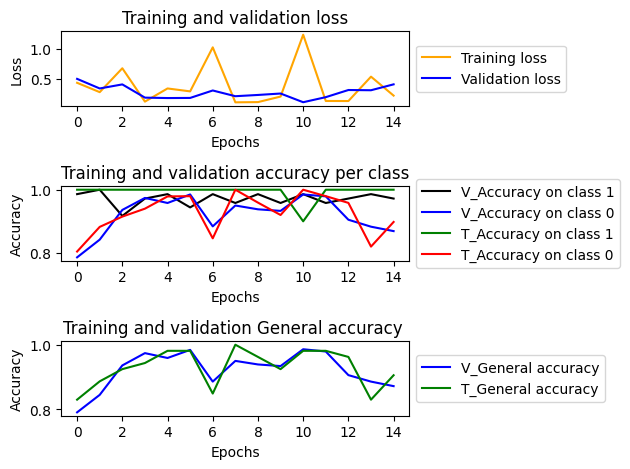

In [14]:
#Visualize data

figure, axis = plt.subplots(3, 1)
csv_file=pd.read_csv(filename)
axis[0].plot(csv_file["epoch"], csv_file["loss"], color='orange', label='Training loss')
axis[0].plot(csv_file["epoch"], csv_file["val_loss"], 'b', label='Validation loss')
axis[0].set_title('Training and validation loss')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axis[1].plot(csv_file["epoch"], csv_file["acc1"], color='black', label='V_Accuracy on class 1')
axis[1].plot(csv_file["epoch"], csv_file["acc0"], 'b', label='V_Accuracy on class 0')
axis[1].plot(csv_file["epoch"], csv_file["acc1_train"], color='green', label='T_Accuracy on class 1')
axis[1].plot(csv_file["epoch"], csv_file["acc0_train"], color='red', label='T_Accuracy on class 0')
axis[1].set_title('Training and validation accuracy per class')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')

axis[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


axis[2].plot(csv_file["epoch"], csv_file["gen acc"], 'b', label='V_General accuracy')
axis[2].plot(csv_file["epoch"], csv_file["accGen_train"], 'g', label='T_General accuracy')
axis[2].set_title('Training and validation General accuracy ')
axis[2].set_xlabel('Epochs')
axis[2].set_ylabel('Accuracy')
axis[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig("Metrics"+str(batch_size)+".png")
plt.show()

In [15]:
#test

num_batches = len(test_dataloader)
if FT :
    if augment :
        testname='testAugmFT'+str(batch_size)+"_"+str(epochs)+"epo"+'.csv'
    else:
        testname='testVanillaFT'+str(batch_size)+"_"+str(epochs)+"epo"+'.csv'
else:
    if augment :
        testname='testAugmFE'+str(batch_size)+"_"+str(epochs)+"epo"+'.csv'
    else:
        testname='testFE'+str(batch_size)+"_"+str(epochs)+"epo"+'.csv'
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    with open(testname, 'w', newline='') as file:
        writer = csv.writer(file)
        field = ["image_name","target"]
        writer.writerow(field)
        for test_batch, (test_X, name) in tqdm(enumerate(test_dataloader)):
            test_X = test_X.to(device)
            test_pred = model(test_X)
            predicted_labels=torch.sigmoid(test_pred)

            for i,x in enumerate(predicted_labels) :
                # print(test_batch)
                # print(i)
                writer.writerow([name[i],round(x.item(),3)])
print(testname+" done!")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
172it [00:39,  4.38it/s]

testAugmFE64_15epo.csv done!
